# Recovering matrices

Most of my research is focused on predicting matrix-valued data ('pairwise learning'). This works by either having features of the rows and columns or by exploiting some kind of structure in the matrix. One particularly appealing type of structure is that a matrix $X$ is low rank, i.e.

$$
X \approx UV^\intercal\,,
$$

where both $U$ and $V$ are 'long': they have many rows but few columns. Many large matrices can be modelled as such, since it is assumed that there are only a couple of hidden variables that explain the data. This principle is widely used in unsupervised learning (factorization methods such as PCA and the like) and can be exploited to, for example, find the [topmost relevant items efficiently](https://link.springer.com/article/10.1007/s10618-016-0456-z).

One way to find low-rank matrices is by adding the nuclear norm as a matrix regularizer. This could recover a low-rank matrix. Only very recently it finally clicked in my mind how this works. This post is a small technical note on how to use empirical risk minimization to recover matrices, with an emphasis low-rank and positive semi-definite ones. As an illustration, I will show that with some straightforward code, we can obtain a better estimate of a correlation matrix.

In [1]:
using CSV, Statistics, LinearAlgebra, DataFrames
using Plots

## Recovering matrices

Suppose we have matrix $Y$ of observations, for example user-item ratings, interaction values between drugs and protein targets, or the adjacency matrix of a food web. If we expect that the values of $Y$ are corrupted or if $Y$ is incomplete, we need to re-estimate $Y$ by a hopefully better matrix $X$. In machine learning, such problems are approached by solving an *empirical risk minimization problem* (ERMP): 

$$
\min_X l(Y, X) +\lambda \cdot h(X)\,.
$$

This optimization problem has typically three parts:

- a *loss function* $l(\cdot, \cdot)$ which quantifies how well the matrix $X$ approximates our observed matrix $Y$;
- a *regularization function* $h(\cdot)$, which we can use to impose some structure on the matrix $X$;
- a *regularization parameter* $\lambda$, a turing switch to adjust the relative trade-off between the two terms above.

For the loss function, there are plenty of options, depending on the nature of the data (regression, classification, many outliers...). We will just focus on the vanilla squared loss:

$$
l(Y, X) = \sum_{i,j}(Y_{ij}-X_{ij})^2\,,
$$

which is most appropriate if the elements of $Y$ are real-valued and meausurement errors are close to normally distributed. Note that if not all the values of $Y$ are observed, we can trivially deal with this by just taking the sum over the sampled values.

If we only minimize a loss, we will just obtain a matrix $X$ with exactly the same content as $Y$, not particularly exciting! The magic of the regularizer is that it will impose some structure on the learnt matrix $X$. The most basic assumption we can make is that the values of $X$ should not be 'too large', which can be enforced by $L_2$: regularization:

$$
h_{L_2}(X) = \sum_{i,j} X_{ij}^2\,.
$$

The $L_2$ norm ensures that no value in $X$ can grow too large, as the penalty is proportional to the squared value. The nice thing about this, if that in conjunction with the squared loss, the empirical risk minimization problem yields a closed-form solution. 

A popular alternative to $L_2$ regularization is by using $L_1$-norm instead:

$$
h_{L_1}(X) = \sum_{i,j} |X_{ij}|\,.
$$

The $L_1$ norm enforces *sparsity*: many of the values in $X$ will be driven to zero. Additionally, the $L_1$,  regulalizer, in contrast to $L_2$, is also more tolerant to having some larger values in $X$ (linear vs. quadratic penalty).

What if, rather than having some demands on the individual values of $X$, we want this matrix to be 'simple' in a more global way? One way how $X$ can be simple, is by searching for an $X$ with a low rank, i.e. one that can be represented by a few dimensions. Is there a simple way to guide $X$ towards having a low rank? Yes! This can be done by considering the nuclear norm:

$$
||X||_\star = \sqrt{\text{tr}(X^\intercal X)}\,,
$$

which leads to a regularizer:

$$
h_\text{nucl}(X) = \text{tr}(X^\intercal X)\,.
$$

So the trace (taking the sum of the diagonal values of a matrix) apparently holds the key to finding low-rank matrices. The reason is quite an interesting exercise in linear algebra. Note that the [singular value decompostion](https://en.wikipedia.org/wiki/Singular_value_decomposition) of $X$ is written as:

$$
X = \sum_k\sigma_k\mathbf{u}_k\mathbf{v}^\intercal_k\,,
$$

with $\mathbf{u}_1, \mathbf{u}_2,\ldots$ and $\mathbf{v}_1, \mathbf{u}_2,\ldots$ two sets of orthonormal eigenvectors and $\sigma_1, \sigma_2,\ldots$ the eigenvalues of $X^\intercal X$. If $X$ is low rank, this means that many of these eigenvalues are zero. Note that these eigenvalues are all non-negative reals if $X$ is real-valued. The trace of a matrix is equal to the sum of its eigenvalues, hence we can write

$$
\text{tr}(X^\intercal X) = \sum_k \sigma_k = \sum_k |\sigma_k|\,.
$$

This means that the trace will place an $L_2$ regularization on the eigenvalues. Large values of the regularization parameter $\lambda$ will drive many of the eigenvalues to zero, ensuring that $X$ will be low rank[^UV].

[^UV]: You might wonder why not simply reformulate the problem by substituting $X$ by $UV^\intercal$ and minimize the objective w.r.t. $U$ and $V$. In this case, the problem is no longer convex and has no longer an unique solution (swapping any corresponding of $U$ and the corresponding ones in $V$ yields the same objective value). The optimization problem will no longer have a single minimum is is thus harder to solve.

## Illustration: approximating a covariance matrix

Let us illustrate this on a related problem: re-estimating a covariance matrix[^kernel]. Similar to the ERMP of above, we have a covariance matrix $\Sigma$ which we want to approximate by a matrix $S$ (for example because $\Sigma$ is subjected to high variance during estimation). The problem becomes:

$$
\min_{S\succeq 0} l(\Sigma, S) + \lambda \cdot h(S)\,.
$$

We restrict ourselves to searching in the [positive semi-definite](https://en.wikipedia.org/wiki/Definiteness_of_a_matrix) (PSD) cone ($S\succeq 0$). Since covariance matrices are PSD, all eigenvalues are non-zero.

We will try this out on the [wines dataset](https://archive.ics.uci.edu/ml/datasets/wine), a small dataset containing 13 chemical and physical characteristics of several wines. We will first compute the covariance matrix and subsequently re-estimate this matrix, penalizing the $L_2$-, $L_1$ and nuclear norm.

[^kernel]: A related problem would be kernel learning, where the goal is to find a good [kernel](https://en.wikipedia.org/wiki/Kernel_method) matrix describing the data.

In [2]:
wines = CSV.read("wines.csv")
variables = String.(names(wines))
describe(wines)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Nothing,Int64,DataType
1,Alcohol,1.9382,1,2.0,3,,0,Int64
2,Malic acid,13.0006,11.03,13.05,14.83,,0,Float64
3,Ash,2.33635,0.74,1.865,5.8,,0,Float64
4,Alcalinity of ash,2.36652,1.36,2.36,3.23,,0,Float64
5,Magnesium,19.4949,10.6,19.5,30.0,,0,Float64
6,Total phenols,99.7416,70,98.0,162,,0,Int64
7,Flavanoids,2.29511,0.98,2.355,3.88,,0,Float64
8,Nonflavanoid phenols,2.02927,0.34,2.135,5.08,,0,Float64
9,Proanthocyanins,0.361854,0.13,0.34,0.66,,0,Float64


We use $\Sigma$ to denote the unbiased estimator of the covariance.

In [3]:
# convert DataFrame to Matrix
X = convert(Matrix, wines)
Σ = cov(X)

13×13 Array{Float64,2}:
  0.600679   -0.206515    0.379039   …  -0.109368    -0.433737   
 -0.206515    0.659062    0.0856113     -0.0133134    0.0416978  
  0.379039    0.0856113   1.24802       -0.143326    -0.292447   
 -0.0105554   0.0471152   0.050277      -0.00468215   0.000761836
  1.34036    -0.841093    1.07633       -0.209118    -0.656234   
 -2.3155      3.13988    -0.87078    …   0.180851     0.669308   
 -0.348835    0.146887   -0.234338       0.0620389    0.311021   
 -0.656091    0.192033   -0.45863        0.124082     0.558262   
  0.0471774  -0.0157543   0.0407334     -0.00747118  -0.0444692  
 -0.221413    0.0635175  -0.141147       0.0386646    0.210933   
  0.477339    1.02828     0.644838   …  -0.276506    -0.705813   
 -0.109368   -0.0133134  -0.143326       0.052245     0.0917662  
 -0.433737    0.0416978  -0.292447       0.0917662    0.504086   

We will use a [simple gradient descent](https://michielstock.github.io/ConvexSummary/) to solve the ERMP. During the gradient updates, it is possible that $S$ is no longer positive semi-definite. For this reason, we will have to project back in the positive semi-definite cone in every step. This can be done by setting negative eigenvalues to zero.

In [4]:
function projectSPDcone!(S)
    vals, vectors = eigen(S)
    vals[vals .< 0.0] .= 0.0
    S .= vectors * Diagonal(vals) * vectors'
    return S
end

projectSPDcone! (generic function with 1 method)

Similarly, we can use soft-thresholding to set very small values to zero. This is an easy way to make sparse solutions possible.

In [5]:
function softthreshold!(X, tol::Real=1e-4)
    X[abs.(X) .< tol] .= 0.0
end

softthreshold! (generic function with 2 methods)

We also need the gradient of loss and regularization functions. These can be computed using automatic differentiation methods, but since the functions are so simple, let's provide them explicitly:

In [6]:
∇ls(Y, X) = 2(X .- Y)

∇ls (generic function with 1 method)

In [7]:
∇L₂(X) = 2X
∇L₁(X) = sign.(X)
∇nucl(S) = sign.(Diagonal(S))

∇nucl (generic function with 1 method)

Note that here the nuclear regularization is directly on the matrix, since it is already symmetric and PSD.

Putting this all together, we have obtain a general gradient descent function to approximate PSD matrices.

In [8]:
function PSDapprox(Σ::AbstractArray, ∇norm::Function, ∇loss=∇ls;
                λ=1.0, stepsize=1e-3, maxitter=20_000, tol=1e-4)
    S = copy(Σ)
    ΔS = similar(S)
    for i in 1:maxitter
        # compute gradient of loss + norm
        ΔS .= ∇ls(Σ, S) + λ * ∇norm(S)
        # stop if the gradient is small
        if norm(ΔS) < tol
            break
        end
        S -= stepsize * ΔS
        # project back into the SPD cone
        S .= projectSPDcone!(S)
        # soft thresholding
        softthreshold!(S, tol)
    end
    S
end

PSDapprox (generic function with 2 methods)

Let us try for the different regularizers:

In [9]:
SL₂ = PSDapprox(Σ, ∇L₂, λ=2e-1)

13×13 Array{Float64,2}:
  0.500566    -0.172096    0.315866   …  -0.0911396   -0.361448   
 -0.172096     0.549219    0.0713428     -0.0110945    0.0347482  
  0.315866     0.0713428   1.04001       -0.119438    -0.243706   
 -0.00879621   0.0392626   0.0418975     -0.0039018    0.000634863
  1.11697     -0.700911    0.896943      -0.174265    -0.546862   
 -1.92958      2.61657    -0.72565    …   0.150709     0.557757   
 -0.290696     0.122406   -0.195281       0.0516991    0.259184   
 -0.546742     0.160028   -0.382192       0.103402     0.465219   
  0.0393145   -0.0131286   0.0339445     -0.00622598  -0.0370577  
 -0.184511     0.0529313  -0.117623       0.0322205    0.175777   
  0.397783     0.856902    0.537365   …  -0.230422    -0.588177   
 -0.0911396   -0.0110945  -0.119438       0.0435375    0.0764719  
 -0.361448     0.0347482  -0.243706       0.0764719    0.420072   

In [10]:
SL₁ = PSDapprox(Σ, ∇L₁, λ=2e-1)

13×13 Array{Float64,2}:
  0.502745   -0.105621      0.279187     …  -0.0208615    -0.335675  
 -0.105621    0.55945       0.000142351      0.0           0.0       
  0.279187    0.000142351   1.14803         -0.0441496    -0.192586  
  0.0         0.0           0.0             -0.000107562   0.0       
  1.23978    -0.741346      0.97629         -0.10587      -0.555687  
 -2.2155      3.03988      -0.77078      …   0.0808711     0.569311  
 -0.249459    0.0466174    -0.134382         0.0           0.211606  
 -0.554226    0.0928404    -0.358497         0.0137052     0.456512  
  0.0         0.0           0.0             -0.000149592   0.0       
 -0.121912    0.0          -0.0411828        0.0           0.111401  
  0.376425    0.927887      0.544773     …  -0.171415     -0.604954  
 -0.0208615   0.0          -0.0441496        0.0162355     0.00255751
 -0.335675    0.0          -0.192586         0.00255751    0.405906  

In [11]:
Snucl = PSDapprox(Σ, ∇nucl, λ=2e-1)

13×13 Array{Float64,2}:
  0.523474   -0.2018      0.378216   …  -0.102672    -0.425452  
 -0.2018      0.560289    0.0853282     -0.0146486    0.0434516 
  0.378216    0.0853282   1.14846       -0.138243    -0.292814  
  0.0         0.0474372   0.0479655     -0.00677665   0.00514546
  1.33877    -0.841296    1.07649       -0.209159    -0.656809  
 -2.31547     3.1399     -0.870777   …   0.180832     0.669327  
 -0.360782    0.143824   -0.234054       0.0621105    0.307935  
 -0.642777    0.195738   -0.459109       0.121481     0.562478  
  0.0496407  -0.0149893   0.0401001     -0.00982623  -0.0395298 
 -0.223001    0.062717   -0.141305       0.0383765    0.21024   
  0.476298    1.02801     0.645162   …  -0.273265    -0.706216  
 -0.102672   -0.0146486  -0.138243       0.0302173    0.0936902 
 -0.425452    0.0434516  -0.292814       0.0936902    0.407482  

If these matrices are compared with the original matrix $\Sigma$, you notice that the values have been shrunken by the regularization: we we sacrifice unbiasedness for a large drop in variance! As promised, the coviance matrix obtained by using $L_1$ regularization is quite sparse.

In [12]:
println("sparsity SL₂: $(mean(SL₂.==0))")
println("sparsity SL₁: $(mean(SL₁.==0))")
println("sparsity Snucl: $(mean(Snucl.==0))")

sparsity SL₂: 0.0
sparsity SL₁: 0.2603550295857988
sparsity Snucl: 0.011834319526627219


A look at the spectrum of all matrices shows that the nuclear norm results in low-rank matrices. 

In [13]:
spectrum(S) = sort(real(eigvals(S)), rev=true)

spectrum (generic function with 1 method)

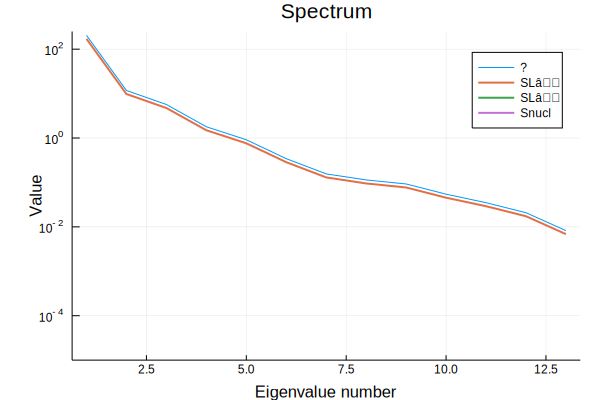

In [14]:
plot(spectrum(Σ), label="Σ")
plot!(spectrum(SL₂), label="SL₂", lw=2)
plot!(spectrum(SL₁), label="SL₁", lw=2)
plot!(spectrum(Snucl), label="Snucl", lw=2)
yaxis!("Value", :log10)
xaxis!("Eigenvalue number")
ylims!(1e-5, 250)
title!("Spectrum")

Checking the rank explicitly:

In [15]:
println("rank Σ: $(rank(Σ, rtol=1e-6))")
println("rank SL₂: $(rank(SL₂, rtol=1e-6))")
println("rank SL₁: $(rank(SL₁, rtol=1e-6))")
println("rank Snucl: $(rank(Snucl, rtol=1e-6))")

rank Σ: 13
rank SL₂: 13
rank SL₁: 12
rank Snucl: 8


As claimed.

## Conclusion

Many machine learning problems can be posed as recovering a matrix (e.g. edge prediction in a graph, collaborative filtering, image inpainting...). Emperical risk minization is a general framework to think about such problems, where the regualarization penalty can be used to impose some structure on the learned matrix. 